# [Source](https://langchain-ai.github.io/langgraph/tutorials/get-started/2-add-tools/)

In [1]:
from dotenv import load_dotenv
load_dotenv()
import os
from langchain_tavily import TavilySearch
from langchain_ollama import ChatOllama

In [2]:
ollama_model = os.getenv("ollama_model")

In [3]:
llm = ChatOllama(
    model=ollama_model,
    reasoning=True
)

In [4]:
tool = TavilySearch(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

{'query': "What's a 'node' in LangGraph?",
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.ionio.ai/blog/a-comprehensive-guide-about-langgraph-code-included',
   'title': 'A Comprehensive Guide About Langgraph: Code Included - Ionio',
   'content': 'A node can be any function or tool your agent uses in langgraph and these nodes are connected with other nodes using edges. Every workflow ends with a “END”',
   'score': 0.89166987,
   'raw_content': None},
  {'url': 'https://medium.com/@kbdhunga/beginners-guide-to-langgraph-understanding-state-nodes-and-edges-part-1-897e6114fa48',
   'title': "Beginner's Guide to LangGraph: Understanding State, Nodes, and ...",
   'content': 'Nodes: Nodes are the fundamental building blocks of a graph. Each node represents a specific function or operation that processes the current',
   'score': 0.8386933,
   'raw_content': None}],
 'response_time': 1.28,
 'request_id': 'd5c491a1-b85d-4a7f-bb4f-9db69dc82ca9'

In [5]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [6]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [7]:
graph_builder = StateGraph(State)

In [8]:
# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)

In [9]:
def chatbot(state: State):
    print(state["messages"])
    return {"messages": [
        llm_with_tools.invoke(state["messages"])
    ]}

In [10]:
graph_builder.add_node("chatbot", chatbot)

In [11]:
import json
from langchain_core.messages import ToolMessage

In [12]:
class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}

In [13]:
tool_node = BasicToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

In [14]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END

In [15]:
# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)

In [16]:
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

In [17]:
from IPython.display import Image, display

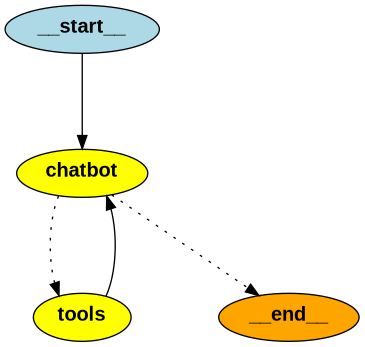

In [18]:
g = graph.get_graph()
png = g.draw_png()     # pygraphviz + graphviz 필요
display(Image(png))

In [19]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

In [20]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

[HumanMessage(content='What do you know about LangGraph?', additional_kwargs={}, response_metadata={}, id='aa2f52f3-50f2-4296-ace3-b70dd46335f5')]
Assistant: 
Assistant: {"query": "LangGraph", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.ibm.com/think/topics/langgraph", "title": "What is LangGraph? - IBM", "content": "LangGraph, created by LangChain, is an open source AI agent framework designed to build, deploy and manage complex generative AI agent workflows. It provides a set of tools and libraries that enable users to create, run and optimize large language models (LLMs) in a scalable and efficient manner. At its core, LangGraph uses the power of graph-based architectures to model and manage the intricate relationships between various components of an AI agent workflow. [...] Agent systems: LangGraph provides a framework for building agent-based systems, which can be used in applications such as robotics, autonomous vehicles or video g

## Use prebuilts

In [ ]:
from typing import Annotated
from langchain_tavily import TavilySearch
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

In [ ]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [ ]:
graph_builder = StateGraph(State)

In [ ]:
tool = TavilySearch(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)

In [ ]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [ ]:
graph_builder.add_node("chatbot", chatbot)

In [ ]:
tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [ ]:
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
    {"tools": "tools", END: END},
)

In [ ]:
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

In [ ]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break